In [1]:
import numpy as np
import h5py
import glob, os, re, sys

from PRFMData import PRFMDataset
import astro_helper as ah

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
ETG_vlM = PRFMDataset(
    galaxy_type="ETG-vlM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [3]:
ETG_lowM = PRFMDataset(
    galaxy_type="ETG-lowM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [4]:
ETG_medM = PRFMDataset(
    galaxy_type="ETG-medM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [5]:
ETG_hiM = PRFMDataset(
    galaxy_type="ETG-hiM",
    total_height=0.3, # kpc
    Rmax=2., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [6]:
NGC300 = PRFMDataset(
    galaxy_type="NGC300",
    total_height=1.5, # kpc
    Rmax=6., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_799.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [7]:
MW = PRFMDataset(
    galaxy_type="MW",
    total_height=1.5, # kpc
    Rmax=6., # kpc
    phibin_sep=np.pi/12.,
    snapname="snap-DESPOTIC_600.hdf5",
    exclude_temp_above=1.e4,
    exclude_avir_below=2.,
    realign_galaxy_to_disk=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

# calculate the integrand of the ISM weight for each case, to check if it's symmetrical

In [8]:
from scipy.signal import savgol_filter as sg
polyno=2
wndwlen=5

In [9]:
data = [ETG_vlM, ETG_lowM, ETG_medM, ETG_hiM, NGC300, MW]
zbin_centers = [instance.zbin_centers_ptl for instance in data]
labels = ['ETG', 'ETG', 'ETG quenched', 'ETG', 'NGC300', 'MW']

In [10]:
integrands = []
for instance in data:
    rho = instance.get_gas_density_Rphiz(zbinsep=instance.zbin_sep_ptl)
    ptl = instance.get_potential_Rphiz()

    dz = sg(instance.zbin_centers_3d_ptl, wndwlen, polyno, deriv=1, axis=2)
    dPhi = sg(ptl, wndwlen, polyno, deriv=1, axis=2)
    dPhidz = dPhi/dz

    integrand = rho * dPhidz * instance.zbin_sep_ptl
    integrands.append(integrand)
    print("finished one")

finished one
finished one
finished one
finished one
finished one
finished one


-1.158735710246823e-14 -1.1587357102468163e-14
5.214594663689364e-13 5.214594663689362e-13
-3.1060988700722185e-13 -3.1060988700722185e-13
1.1466663344510372e-12 1.1466663344510384e-12
-3.757330971114348e-14 -3.757330971114351e-14
8.5603149025783e-14 8.560314902578315e-14


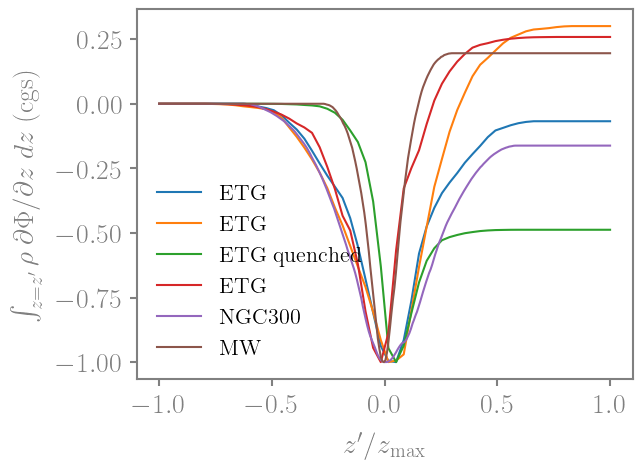

In [45]:
for zbins, integrand, label in zip(zbin_centers, integrands, labels):
    sum = np.sum(np.median(integrand, axis=(0,1)))
    cumsum = np.cumsum(np.median(integrand, axis=(0,1)))
    print(sum, cumsum[-1])
    plt.plot(zbins/np.max(zbins), cumsum/np.max(np.fabs(cumsum)), label=label)
plt.ylabel(r'$\int_{z=z^\prime}{\rho \; \partial \Phi/\partial z \; dz}$ (cgs)')
plt.xlabel(r'$z^\prime/z_{\rm max}$')
plt.legend(frameon=False, loc='lower left', fontsize=16)
plt.show()

# compare ISM weights calculated assuming symmetry to those calculated after removing the net force on the disk COM

In [46]:
Rbin_centers = [instance.Rbin_centers for instance in data]

In [78]:
weights_sym, weights_asym = [], []
weights_left, weights_right = [], []
for integrand in integrands:
    weights_sym.append(0.5*np.sum(np.fabs(integrand), axis=2))
    
    # find the z-coordinate of the potential minimum (force mid-plane)
    z_mp_idcs = np.argmin(np.cumsum(integrand, axis=2), axis=2)

    # compute the weight from both sides
    weight_left, weight_right = np.zeros((integrand.shape[:2])), np.zeros((integrand.shape[:2]))
    for i in range(z_mp_idcs.shape[0]):
        for j in range(z_mp_idcs.shape[1]):
            idx = z_mp_idcs[i, j]
            weight_left[i,j] = np.sum(integrand[i, j, :idx])
            weight_right[i,j] = np.sum(integrand[i, j, idx:])

    weights_left.append(weight_left)
    weights_right.append(weight_right)
    weights_asym.append(0.5*(np.fabs(weight_left) + np.fabs(weight_right)))
    #weights_asym.append(np.sum(np.fabs(integrand), axis=2) - force)

/tmp/ipykernel_3594234/1420320126.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(Rbins/ah.kpc_to_cm, np.log10(np.median(weight_right, axis=1)/ah.kB_cgs), alpha=0.5, lw=2, color=plt.cm.tab10(i))


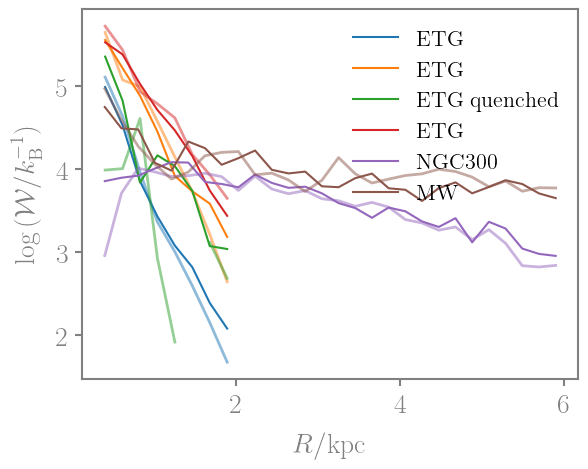

In [79]:
for Rbins, weight_left, weight_right, label, i in zip(Rbin_centers, weights_left, weights_right, labels, range(len(labels))):
    plt.plot(Rbins/ah.kpc_to_cm, np.log10(-np.median(weight_left, axis=1)/ah.kB_cgs), label=label, color=plt.cm.tab10(i))
    plt.plot(Rbins/ah.kpc_to_cm, np.log10(np.median(weight_right, axis=1)/ah.kB_cgs), alpha=0.5, lw=2, color=plt.cm.tab10(i))
plt.ylabel(r'$\log{(\mathcal{W}/k_{\rm B}^{-1})}$')
plt.xlabel(r'$R/{\rm kpc}$')
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.show()

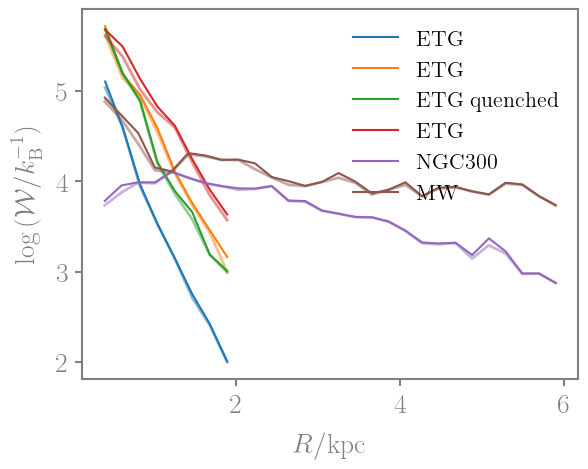

In [80]:
for Rbins, weight_sym, weight_asym, label, i in zip(Rbin_centers, weights_sym, weights_asym, labels, range(len(labels))):
    plt.plot(Rbins/ah.kpc_to_cm, np.log10(np.median(weight_sym, axis=1)/ah.kB_cgs), label=label, color=plt.cm.tab10(i))
    plt.plot(Rbins/ah.kpc_to_cm, np.log10(np.median(weight_asym, axis=1)/ah.kB_cgs), alpha=0.5, lw=2, color=plt.cm.tab10(i))
plt.ylabel(r'$\log{(\mathcal{W}/k_{\rm B}^{-1})}$')
plt.xlabel(r'$R/{\rm kpc}$')
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.show()